In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from math import sqrt
import pickle
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
df.drop(['Unnamed: 0','Location','New_Price'],axis=1,inplace=True)

In [6]:
df.isnull().sum()

,0
Name,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,2
Engine,36
Power,36
Seats,42


In [7]:
manufacturer = df['Name'].str.split(' ',expand=True)
df['Manufacturer'] = manufacturer[0]

In [8]:
curr_time = datetime.datetime.now()
df['Year Used']=df['Year'].apply(lambda x:curr_time.year-x)

In [9]:
df.drop(['Name','Year'],axis=1,inplace=True)

In [10]:
df['Mileage'] = df['Mileage'].astype(str)  # Ensure the column is string
mileage = df['Mileage'].str.split(' ', expand=True)
df['Mileage'] = pd.to_numeric(mileage[0], errors='coerce')
df['Mileage'].fillna(df['Mileage'].mean(), inplace=True)

In [11]:
engine = df['Engine'].str.split(' ',expand=True)
df['Engine']=pd.to_numeric(engine[0],errors='coerce')
df['Engine'].fillna(df['Engine'].astype('float').mean(),inplace=True)

In [12]:
power = df['Power'].str.split(' ',expand=True)
df['Power']=pd.to_numeric(power[0],errors='coerce')
df['Power'].fillna(df['Power'].astype('float').mean(),inplace=True)

In [13]:
df['Seats'].fillna(df['Seats'].astype('float').mean(),inplace=True)

In [14]:
df.isnull().sum()

,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,0
Engine,0
Power,0
Seats,0
Price,0
Manufacturer,0


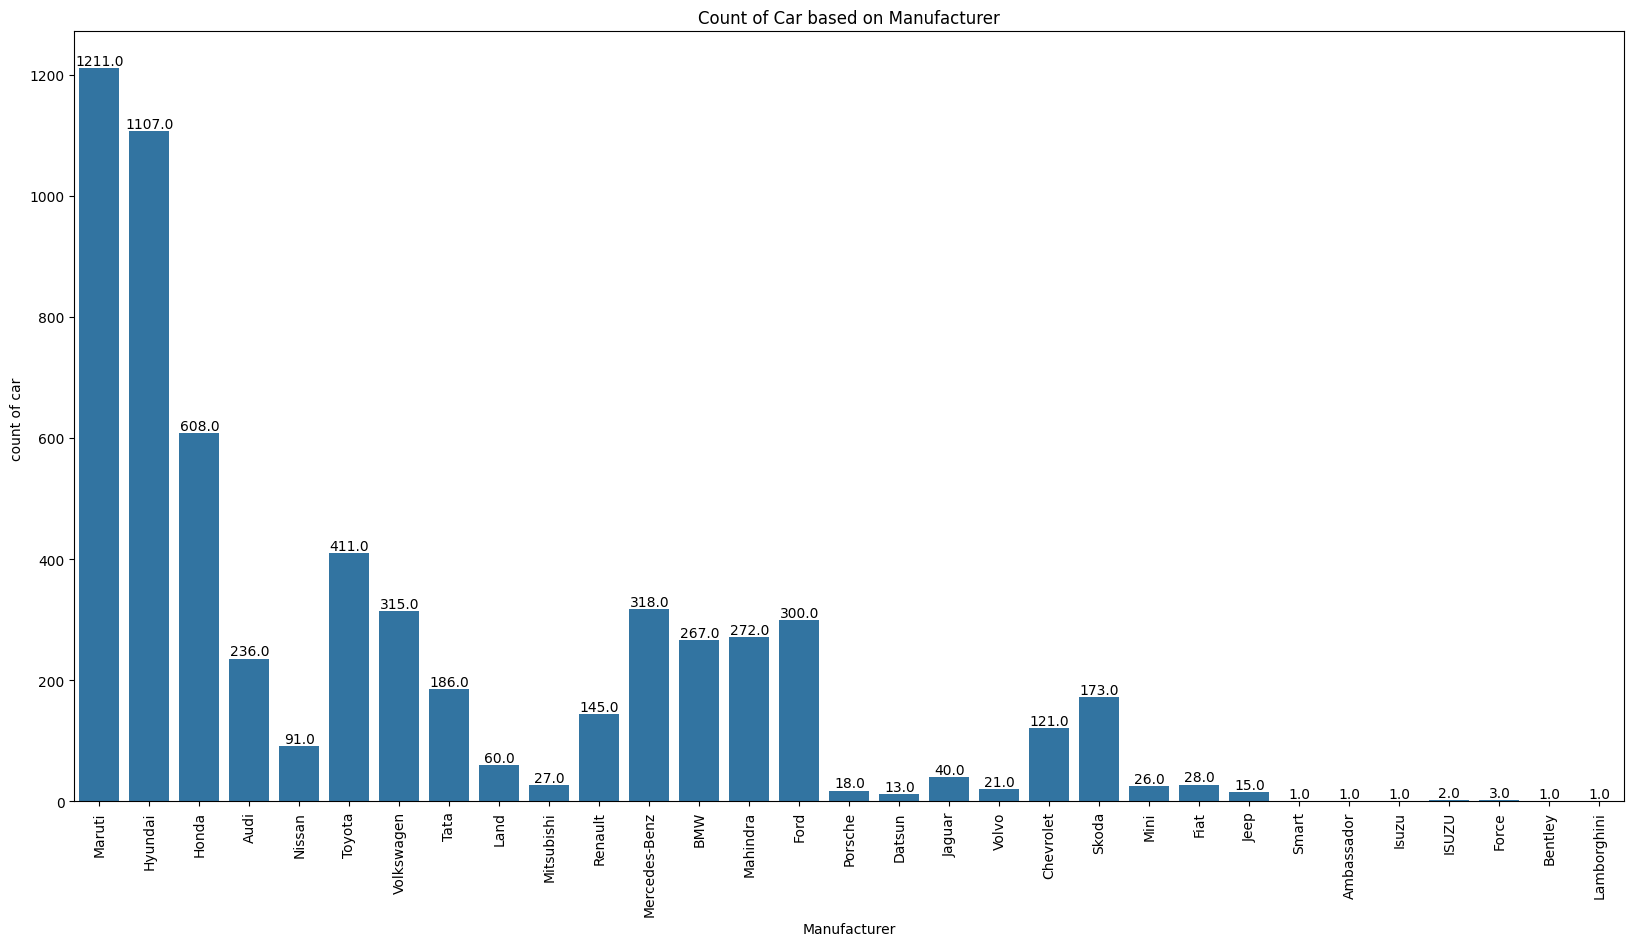

In [15]:
plt.rcParams['figure.figsize']=(20,10)
plot = sns.countplot(x='Manufacturer',data = df)
plt.xticks(rotation=90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+p.get_width()/2.0,p.get_height()),
                  ha='center',va='center',xytext=(0,5),textcoords='offset points')
plt.title('Count of Car based on Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('count of car ')
plt.savefig('Count of Car.png')
plt.show()

In [16]:
# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

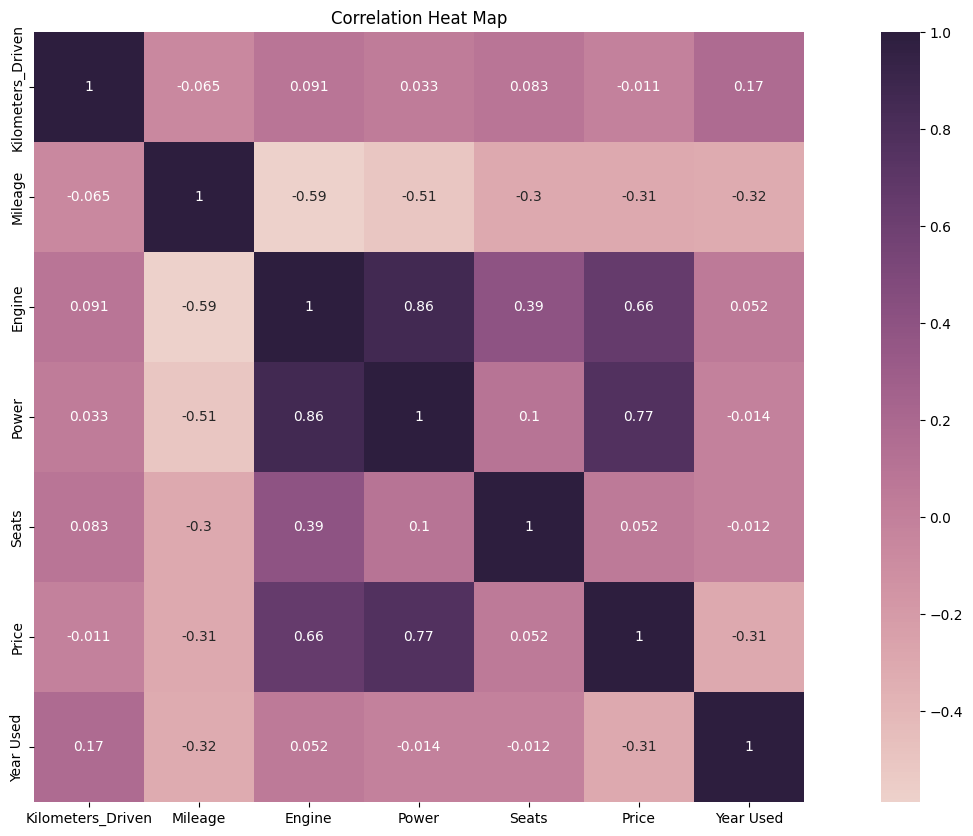

In [17]:
# Select only numerical columns
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr = numerical_df.corr()



sns.heatmap(corr, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), cbar=True, square=True)
plt.title('Correlation Heat Map')
plt.show()

In [18]:
x = df.drop(['Price'],axis=1)
y = df['Price']

In [19]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=45)

In [20]:
x_train = pd.get_dummies(x_train,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_train.shape)

(4213, 42)


In [21]:
x_test = pd.get_dummies(x_test,columns=['Manufacturer','Fuel_Type','Transmission','Owner_Type'],drop_first=True)
print(x_test.shape)

(1806, 38)


In [22]:
miss_col = set(x_train.columns)-set(x_test.columns)
for col in miss_col:
    x_test[col]=0
x_test = x_test[x_train.columns]

In [23]:
print('X_train',x_train.shape)
print('X_test',x_test.shape)

X_train (4213, 42)
X_test (1806, 42)


In [24]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.fit_transform(x_test)

In [25]:
def FitModel(x,y,algo_name,algorithm,gridSearchParams,cv):
    np.random.seed(10)
    grid = GridSearchCV(estimator=algorithm,param_grid=gridSearchParams,scoring='r2',verbose=0,cv=cv,n_jobs=-1)
    grid_result = grid.fit(x_train,y_train)
    best_params = grid_result.best_params_
    y_pred = grid_result.predict(x_test)
    pickle.dump(grid_result,open(algo_name,'wb'))
    print('\n R2 Score:{}%'.format(100*r2_score(y_test,y_pred)))
    print('\n Mean Absolute Error:',mean_absolute_error(y_test,y_pred))
    print('\n Mean Squared Error:',mean_squared_error(y_test,y_pred))
    print('\n Root Mean Squared Error:',sqrt(mean_squared_error(y_test,y_pred)))

In [26]:
params = {}
FitModel(x,y,'Linear Regression',LinearRegression(),params,cv=10)


 R2 Score:76.90457787320157%

 Mean Absolute Error: 2.9688979955213273

 Mean Squared Error: 28.66648456664555

 Root Mean Squared Error: 5.354109129131153


In [27]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)


 R2 Score:89.16507697440488%

 Mean Absolute Error: 1.8262045776492803

 Mean Squared Error: 13.448515986794442

 Root Mean Squared Error: 3.6672218349582346


In [28]:
params = {}
FitModel(x,y,'Lasso',Lasso(),params,cv=10)


 R2 Score:72.26180392554386%

 Mean Absolute Error: 3.36959244043127

 Mean Squared Error: 34.42918537316263

 Root Mean Squared Error: 5.867638824362201


In [29]:
params = {}
FitModel(x,y,'Ridge',Ridge(),params,cv=10)


 R2 Score:76.56033098690982%

 Mean Absolute Error: 2.979234626544081

 Mean Squared Error: 29.09377045901068

 Root Mean Squared Error: 5.393864149105971


In [30]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Random Forest',RandomForestRegressor(),params,cv=10)


 R2 Score:89.16507697440488%

 Mean Absolute Error: 1.8262045776492803

 Mean Squared Error: 13.448515986794442

 Root Mean Squared Error: 3.6672218349582346


In [31]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)


 R2 Score:91.1328292802006%

 Mean Absolute Error: 1.674786542310545

 Mean Squared Error: 11.006103772140824

 Root Mean Squared Error: 3.317544841014334


In [32]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'Extra Tree',ExtraTreesRegressor(),params,cv=10)


 R2 Score:91.1328292802006%

 Mean Absolute Error: 1.674786542310545

 Mean Squared Error: 11.006103772140824

 Root Mean Squared Error: 3.317544841014334


In [33]:
params = {'n_estimators':[44,109,314],
         'random_state':[45]}
FitModel(x,y,'XG Boost',XGBRegressor(),params,cv=10)


 R2 Score:85.80193208416446%

 Mean Absolute Error: 2.2338060955747814

 Mean Squared Error: 17.622916461579564

 Root Mean Squared Error: 4.197965752787838
